# Image De-blurring by Supervised Learning

## import libraries

In [400]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
import math
from math import log10
from tqdm import tqdm
import random
import os

## load data

In [401]:
directory_data  = './'
filename_data   = 'assignment_11_data.npz'
data            = np.load(os.path.join(directory_data, filename_data))

original_train  = data['original_train']
blur_train      = data['blur_train']

original_test   = data['original_test']
blur_test       = data['blur_test']

num_data_train  = original_train.shape[0]
num_data_test   = original_test.shape[0]

print('*************************************************')
print('size of original_train :', original_train.shape)
print('size of blur_train :', blur_train.shape)
print('*************************************************')
print('size of original_test :', original_test.shape)
print('size of blur_test :', blur_test.shape)
print('*************************************************')
print('number of training image :', original_train.shape[0])
print('height of training image :', original_train.shape[1])
print('width of training image :', original_train.shape[2])
print('*************************************************')
print('number of testing image :', original_test.shape[0])
print('height of testing image :', original_test.shape[1])
print('width of testing image :', original_test.shape[2])
print('*************************************************')

*************************************************
size of original_train : (200, 256, 256)
size of blur_train : (200, 256, 256)
*************************************************
size of original_test : (100, 256, 256)
size of blur_test : (100, 256, 256)
*************************************************
number of training image : 200
height of training image : 256
width of training image : 256
*************************************************
number of testing image : 100
height of testing image : 256
width of testing image : 256
*************************************************


## hyper-parameters

In [402]:
device          = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

number_epoch    = 550
size_minibatch  = 200
learning_rate   = 0.09
weight_decay    = 0.01

## custom data loader for the PyTorch framework

In [403]:
class dataset(Dataset):
    
    def __init__(self, original, blur, transform=False):
        
        self.original   = original
        self.blur       = blur 
        self.transform = transform
    
    def __getitem__(self, index):
        
        original    = self.original[index]
        blur        = self.blur[index]

        
        
        original    = torch.FloatTensor(original).unsqueeze(dim=0)
        blur        = torch.FloatTensor(blur).unsqueeze(dim=0)


        original = transforms.Resize(size=[128,128])(original)
        blur = transforms.Resize(size=[128,128])(blur)

        if self.transform:

            crop_size = [64, 64]
            # random crop
            top         = random.randint(0, original.shape[1] - crop_size[0])
            left        = random.randint(0, original.shape[2] - crop_size[1])
            original    = transforms.functional.crop(original, top, left, crop_size[0], crop_size[1])
            blur        = transforms.functional.crop(blur, top, left, crop_size[0], crop_size[1])
            
            # random horizontal flip
            if random.random() > 0.5: 
                original = transforms.functional.hflip(original)
                blur = transforms.functional.hflip(blur)

            # random vertical flip
            if random.random() > 0.5: 
                original = transforms.functional.vflip(original)
                blur = transforms.functional.vflip(blur)

        return (original, blur)
    
    def __len__(self):
        
        return self.original.shape[0]

## construct datasets and dataloaders for training and testing

In [404]:
dataset_train_transform = dataset(original_train, blur_train, transform=True)
dataset_train           = dataset(original_train, blur_train)
dataset_test            = dataset(original_test, blur_test)

dataloader_train_transform  = DataLoader(dataset_train_transform, batch_size=size_minibatch, shuffle=True, drop_last=True)
dataloader_train            = DataLoader(dataset_train, batch_size=1, shuffle=False, drop_last=True)
dataloader_test             = DataLoader(dataset_test, batch_size=1, shuffle=False, drop_last=True)

## shape of the data when using the data loader

In [405]:
(original_train, blur_train)  = dataset_train[0]
(original_test, blur_test)    = dataset_test[0]
(original_train_transform, blur_train_transform)  = dataset_train_transform[0]
print('*******************************************************************')
print('shape of the original in the training dataset:', original_train.shape)
print('shape of the blur in the training dataset:', blur_train.shape)
print('*******************************************************************')
print('shape of the original in the testing dataset:', original_test.shape)
print('shape of the blur in the testing dataset:', blur_test.shape)
print('*******************************************************************')
print('shape of the original in the training transform dataset:', original_train_transform.shape)
print('shape of the blur in the training transform dataset:', blur_train_transform.shape)
print('*******************************************************************')

*******************************************************************
shape of the original in the training dataset: torch.Size([1, 128, 128])
shape of the blur in the training dataset: torch.Size([1, 128, 128])
*******************************************************************
shape of the original in the testing dataset: torch.Size([1, 128, 128])
shape of the blur in the testing dataset: torch.Size([1, 128, 128])
*******************************************************************
shape of the original in the training transform dataset: torch.Size([1, 64, 64])
shape of the blur in the training transform dataset: torch.Size([1, 64, 64])
*******************************************************************


## class for the neural network 

In [406]:
# class Network(nn.Module):
#     def __init__(self):
#         super(Network,self).__init__()

#         self.activationReLu		= nn.ReLU(inplace=True)
#         self.activation		= nn.LeakyReLU(0.1)
#         self.activation_out	= nn.Sigmoid()
#         self.skip = nn.Identity()
      
#         self.mp = nn.MaxPool2d(2,2)
#         self.us = nn.Upsample(scale_factor=2, mode='nearest')

#         self.conv_e1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=1, bias=True)
#         nn.init.xavier_uniform_(self.conv_e1.weight)
#         self.ebn1 = nn.BatchNorm2d(16)

#         self.conv_e2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1, bias=True)
#         nn.init.xavier_uniform_(self.conv_e2.weight)
#         self.ebn2 = nn.BatchNorm2d(32)

#         self.conv_e3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1, bias=True)
#         nn.init.xavier_uniform_(self.conv_e3.weight)
#         self.ebn3 = nn.BatchNorm2d(64)

#         self.conv_e4 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1, bias=True)
#         nn.init.xavier_uniform_(self.conv_e4.weight)
#         self.ebn4 = nn.BatchNorm2d(128)

#         self.conv_e5 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1, bias=True)
#         nn.init.xavier_uniform_(self.conv_e5.weight)
#         self.ebn5 = nn.BatchNorm2d(256)

#         self.conv_e6 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, stride=1, padding=1, bias=True)
#         nn.init.xavier_uniform_(self.conv_e6.weight)
#         self.ebn6  = nn.BatchNorm2d(512)

#         self.conv_e7 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1, bias=True)
#         nn.init.xavier_uniform_(self.conv_e7.weight)
#         self.ebn7  = nn.BatchNorm2d(512)



#         # -------------------------------------------------
#         # Decoder
#         # -------------------------------------------------
#         self.conv_d1 = nn.Conv2d(in_channels=512, out_channels=256, kernel_size=3, stride=1, padding=1, bias=True)
#         nn.init.xavier_uniform_(self.conv_d1.weight)
#         self.dbn1 = nn.BatchNorm2d(256)

#         self.conv_d2 = nn.Conv2d(in_channels=256, out_channels=128, kernel_size=3, stride=1, padding=1, bias=True)
#         nn.init.xavier_uniform_(self.conv_d2.weight)
#         self.dbn2 = nn.BatchNorm2d(128)

#         self.conv_d3 = nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3, stride=1, padding=1, bias=True)
#         nn.init.xavier_uniform_(self.conv_d3.weight)
#         self.dbn3 = nn.BatchNorm2d(64)

#         self.conv_d4 = nn.Conv2d(in_channels=64, out_channels=32, kernel_size=3, stride=1, padding=1, bias=True)
#         nn.init.xavier_uniform_(self.conv_d4.weight)
#         self.dbn4 = nn.BatchNorm2d(32)

#         self.conv_d5 = nn.Conv2d(in_channels=32, out_channels=16, kernel_size=3, stride=1, padding=1, bias=True)
#         nn.init.xavier_uniform_(self.conv_d5.weight)
#         self.dbn5 = nn.BatchNorm2d(16)

#         self.conv_d6 = nn.Conv2d(in_channels=16, out_channels=1, kernel_size=3, stride=1, padding=1, bias=True)
#         nn.init.xavier_uniform_(self.conv_d6.weight)

#     def forward(self,x):
#         out = self.conv_e1(x)
#         out = self.ebn1(out)
#         out = self.activation(out)
#         res1 = out
#         out = self.mp(out)

#         out = self.conv_e2(out)
#         out = self.ebn2(out)
#         out = self.activation(out)
#         res2 = out

#         out = self.conv_e3(out)
#         out = self.ebn3(out)
#         out = self.activation(out)
#         res3 = out

#         out = self.conv_e4(out)
#         out = self.ebn4(out)
#         out = self.activation(out)
#         res4 = out

#         out = self.conv_e5(out)
#         out = self.ebn5(out)
#         out = self.activation(out)
#         res5 = out
#         out = self.mp(out)
        

#         out = self.conv_e6(out)
#         out = self.ebn6(out)
#         out = self.activation(out)
#         res6 = out
#         out = self.mp(out)

#         out = self.conv_e7(out)
#         out = self.ebn7(out)
#         out = self.activation(out)        

#         out = self.us(out)
#         out = out + self.skip(res6)
#         out = self.conv_d1(out)
#         out = self.dbn1(out)
#         out = self.activation(out)
        

#         out = self.us(out)
#         out = out + self.skip(res5)
#         out = self.conv_d2(out)
#         out = self.dbn2(out)
#         out = self.activation(out)
        
#         out = out + self.skip(res4)
#         out = self.conv_d3(out)
#         out = self.dbn3(out)
#         out = self.activation(out)

#         out = out + self.skip(res3)
#         out = self.conv_d4(out)
#         out = self.dbn4(out)
#         out = self.activation(out)

#         out = out + self.skip(res2)
#         out = self.conv_d5(out)
#         out = self.dbn5(out)
#         out = self.activation(out)
        
        
#         out = self.us(out)
#         out = out + self.skip(res1)
#         out = self.conv_d6(out)
#         out = self.activation_out(out)

#         return out

In [407]:
class Network(nn.Module):
    def __init__(self):
        super(Network,self).__init__()

        self.activationReLu		= nn.ReLU(inplace=True)
        self.activation		= nn.LeakyReLU(0.1)
        self.activation_out	= nn.Sigmoid()
        self.skip = nn.Identity()
      
        self.mp = nn.MaxPool2d(2,2)
        self.us = nn.Upsample(scale_factor=2, mode='nearest')

        self.conv_e1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1, bias=True)
        nn.init.xavier_uniform_(self.conv_e1.weight)
        self.ebn1 = nn.BatchNorm2d(32)

        self.conv_e2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=1, padding=1, bias=True)
        nn.init.xavier_uniform_(self.conv_e2.weight)
        self.ebn2 = nn.BatchNorm2d(32)

        self.conv_e3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1, bias=True)
        nn.init.xavier_uniform_(self.conv_e3.weight)
        self.ebn3 = nn.BatchNorm2d(64)

        self.conv_e4 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1, bias=True)
        nn.init.xavier_uniform_(self.conv_e4.weight)
        self.ebn4 = nn.BatchNorm2d(128)

        self.conv_e5 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1, bias=True)
        nn.init.xavier_uniform_(self.conv_e5.weight)
        self.ebn5 = nn.BatchNorm2d(256)

        self.conv_e6 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, stride=1, padding=1, bias=True)
        nn.init.xavier_uniform_(self.conv_e6.weight)
        self.ebn6  = nn.BatchNorm2d(512)

        self.conv_e7 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1, bias=True)
        nn.init.xavier_uniform_(self.conv_e7.weight)
        self.ebn7  = nn.BatchNorm2d(512)



        # -------------------------------------------------
        # Decoder
        # -------------------------------------------------
        self.conv_d1 = nn.Conv2d(in_channels=512, out_channels=256, kernel_size=3, stride=1, padding=1, bias=True)
        nn.init.xavier_uniform_(self.conv_d1.weight)
        self.dbn1 = nn.BatchNorm2d(256)

        self.conv_d2 = nn.Conv2d(in_channels=256, out_channels=128, kernel_size=3, stride=1, padding=1, bias=True)
        nn.init.xavier_uniform_(self.conv_d2.weight)
        self.dbn2 = nn.BatchNorm2d(128)

        self.conv_d3 = nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3, stride=1, padding=1, bias=True)
        nn.init.xavier_uniform_(self.conv_d3.weight)
        self.dbn3 = nn.BatchNorm2d(64)

        self.conv_d4 = nn.Conv2d(in_channels=64, out_channels=32, kernel_size=3, stride=1, padding=1, bias=True)
        nn.init.xavier_uniform_(self.conv_d4.weight)
        self.dbn4 = nn.BatchNorm2d(32)

        self.conv_d5 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=1, padding=1, bias=True)
        nn.init.xavier_uniform_(self.conv_d5.weight)
        self.dbn5 = nn.BatchNorm2d(32)

        self.conv_d6 = nn.Conv2d(in_channels=32, out_channels=1, kernel_size=3, stride=1, padding=1, bias=True)
        nn.init.xavier_uniform_(self.conv_d6.weight)

    def forward(self,x):
        out = self.conv_e1(x)
        out = self.ebn1(out)
        out = self.activation(out)
        res1 = out
        out = self.mp(out)

        out = self.conv_e2(out)
        out = self.ebn2(out)
        out = self.activation(out)
        res2 = out

        out = self.conv_e3(out)
        out = self.ebn3(out)
        out = self.activation(out)
        res3 = out

        out = self.conv_e4(out)
        out = self.ebn4(out)
        out = self.activation(out)
        res4 = out

        out = self.conv_e5(out)
        out = self.ebn5(out)
        out = self.activation(out)
        res5 = out
        out = self.mp(out)
        

        out = self.conv_e6(out)
        out = self.ebn6(out)
        out = self.activation(out)
        res6 = out
        out = self.mp(out)

        out = self.conv_e7(out)
        out = self.ebn7(out)
        out = self.activation(out)        

        out = self.us(out)
        out = out + self.skip(res6)
        out = self.conv_d1(out)
        out = self.dbn1(out)
        out = self.activation(out)
        

        out = self.us(out)
        out = out + self.skip(res5)
        out = self.conv_d2(out)
        out = self.dbn2(out)
        out = self.activation(out)
        
        out = out + self.skip(res4)
        out = self.conv_d3(out)
        out = self.dbn3(out)
        out = self.activation(out)

        out = out + self.skip(res3)
        out = self.conv_d4(out)
        out = self.dbn4(out)
        out = self.activation(out)

        out = out + self.skip(res2)
        out = self.conv_d5(out)
        out = self.dbn5(out)
        out = self.activation(out)
        
        
        out = self.us(out)
        out = out + self.skip(res1)
        out = self.conv_d6(out)
        out = self.activation_out(out)

        return out

## build network

In [408]:
model       = Network().to(device)
# optimizer   = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
optimizer   = torch.optim.Adadelta(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

## compute the prediction

In [409]:
def compute_prediction(model, input):
    # ==================================================
    # fill up the blank
    #
    prediction = model(input)
    # 
    # ==================================================

    return prediction

## compute the loss

In [410]:
def compute_loss(prediction, label):
    # ==================================================
    # fill up the blank
    #
    criterion   = nn.MSELoss()
    # 
    # ==================================================
    loss        = criterion(prediction, label)

    return loss

## compute the accuracy

In [411]:
def compute_accuracy(prediction, label):

    prediction  = prediction.squeeze(axis=1)
    label       = label.squeeze(axis=1)
    mse_loss    = torch.mean((prediction - label) ** 2)

    if mse_loss == 0.0:
        psnr = 100
    else:
        psnr = 10 * torch.log10(1 / mse_loss)

    psnr = psnr.item()
    
    return psnr

## variables for the learning curve

In [412]:
loss_mean_train     = np.zeros(number_epoch)
loss_std_train      = np.zeros(number_epoch)
accuracy_mean_train = np.zeros(number_epoch)
accuracy_std_train  = np.zeros(number_epoch)

loss_mean_test      = np.zeros(number_epoch)
loss_std_test       = np.zeros(number_epoch)
accuracy_mean_test  = np.zeros(number_epoch)
accuracy_std_test   = np.zeros(number_epoch)

## train

In [413]:
def train(model, dataloader):

    loss_epoch      = []
    accuracy_epoch  = []

    model.train()

    for index_batch, (original, blur) in enumerate(dataloader):

        original    = original.to(device)
        blur        = blur.to(device)
        
        prediction  = compute_prediction(model, blur)
        loss        = compute_loss(prediction, original)
        accuracy    = compute_accuracy(prediction, original)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        loss_epoch.append(loss.item())
        accuracy_epoch.append(accuracy)

    loss_mean_epoch     = np.mean(loss_epoch)
    loss_std_epoch      = np.std(loss_epoch)

    accuracy_mean_epoch = np.mean(accuracy_epoch)
    accuracy_std_epoch  = np.std(accuracy_epoch)

    loss        = {'mean' : loss_mean_epoch, 'std' : loss_std_epoch}
    accuracy    = {'mean' : accuracy_mean_epoch, 'std' : accuracy_std_epoch}

    return (loss, accuracy)    


## test

In [414]:
def test(model, dataloader):

    loss_epoch      = []
    accuracy_epoch  = []

    model.eval()

    for index_batch, (original, blur) in enumerate(dataloader):

        original    = original.to(device)
        blur        = blur.to(device)
        
        prediction  = compute_prediction(model, blur)
        loss        = compute_loss(prediction, original)
        accuracy    = compute_accuracy(prediction, original)

        loss_epoch.append(loss.item())
        accuracy_epoch.append(accuracy)

    loss_mean_epoch     = np.mean(loss_epoch)
    loss_std_epoch      = np.std(loss_epoch)

    accuracy_mean_epoch = np.mean(accuracy_epoch)
    accuracy_std_epoch  = np.std(accuracy_epoch)

    loss        = {'mean' : loss_mean_epoch, 'std' : loss_std_epoch}
    accuracy    = {'mean' : accuracy_mean_epoch, 'std' : accuracy_std_epoch}

    return (loss, accuracy)    

## train and test

In [415]:
# ================================================================================
# 
# iterations for epochs
#
# ================================================================================
for i in tqdm(range(number_epoch)):
    
    # ================================================================================
    # 
    # training
    #
    # ================================================================================
    (loss_train, accuracy_train) = train(model, dataloader_train_transform)

    loss_mean_train[i]      = loss_train['mean']
    loss_std_train[i]       = loss_train['std']

    accuracy_mean_train[i]  = accuracy_train['mean']
    accuracy_std_train[i]   = accuracy_train['std']

    # ================================================================================
    # 
    # testing
    #
    # ================================================================================
    (loss_test, accuracy_test) = test(model, dataloader_test)

    loss_mean_test[i]      = loss_test['mean']
    loss_std_test[i]       = loss_test['std']

    accuracy_mean_test[i]  = accuracy_test['mean']
    accuracy_std_test[i]   = accuracy_test['std']

100%|████████████████████████████████████████████████████████████████████████████████| 550/550 [13:32<00:00,  1.48s/it]


---

# functions for visualizing the results 

---

## plot curve

In [416]:
def plot_data_grid(data, index_data, nRow, nCol):
    
    size_col = 1.5
    size_row = 1.5

    fig, axes = plt.subplots(nRow, nCol, constrained_layout=True, figsize=(nCol * size_col, nRow * size_row))

    for i in range(nRow):
        for j in range(nCol):

            k       = i * nCol + j
            index   = index_data[k]

            axes[i, j].imshow(data[index], cmap='gray', vmin=0, vmax=1)
            axes[i, j].xaxis.set_visible(False)
            axes[i, j].yaxis.set_visible(False)

    plt.show()

In [417]:
def plot_data_tensor_grid(data, index_data, nRow, nCol):
    
    size_col = 1.5
    size_row = 1.5

    fig, axes = plt.subplots(nRow, nCol, constrained_layout=True, figsize=(nCol * size_col, nRow * size_row))

    data = data.detach().cpu().squeeze(axis=1)

    for i in range(nRow):
        for j in range(nCol):

            k       = i * nCol + j
            index   = index_data[k]

            axes[i, j].imshow(data[index], cmap='gray', vmin=0, vmax=1)
            axes[i, j].xaxis.set_visible(False)
            axes[i, j].yaxis.set_visible(False)

    plt.show()

In [418]:
def plot_curve_error(data_mean, data_std, x_label, y_label, title):

    plt.figure(figsize=(8, 6))
    plt.title(title)

    alpha = 0.3
    
    plt.plot(range(len(data_mean)), data_mean, '-', color = 'red')
    plt.fill_between(range(len(data_mean)), data_mean - data_std, data_mean + data_std, facecolor = 'blue', alpha = alpha) 
    
    plt.xlabel(x_label)
    plt.ylabel(y_label)

    plt.tight_layout()
    plt.show()

In [419]:
def print_curve(data, index):
    
    for i in range(len(index)):

        idx = index[i]
        val = data[idx]

        print('index = %2d, value = %12.10f' % (idx, val))

In [420]:
def get_data_last(data, index_start):

    data_last = data[index_start:]

    return data_last

In [421]:
def get_max_last_range(data, index_start):

    data_range = get_data_last(data, index_start)
    value = data_range.max()

    return value

In [422]:
def get_min_last_range(data, index_start):

    data_range = get_data_last(data, index_start)
    value = data_range.min()

    return value

---

# functions for presenting the results

---

In [423]:
def function_result_01():

    print('[plot examples of the training original images]')
    print('') 

    nRow = 8
    nCol = 6
    index_data      = np.arange(0, nRow * nCol)
    data_train, _   = dataset_train[index_data]
    data_train      = data_train[0]
    
    plot_data_grid(data_train, index_data, nRow, nCol)

In [424]:
def function_result_02():

    print('[plot examples of the training blur images]')
    print('') 
    
    nRow = 8
    nCol = 6
    index_data      = np.arange(0, nRow * nCol)
    _, data_train   = dataset_train[index_data]
    data_train      = data_train[0]
    
    plot_data_grid(data_train, index_data, nRow, nCol)

In [425]:
def function_result_03():

    print('[plot examples of the training de-blurring results]')
    print('') 

    nRow = 8
    nCol = 6
    index_data          = np.arange(0, nRow * nCol)
    _, data_train       = dataset_train[index_data] 
    data_train          = data_train[0].unsqueeze(dim=1).to(device)
    prediction_train    = compute_prediction(model, data_train)
    
    plot_data_tensor_grid(prediction_train, index_data, nRow, nCol)

In [426]:
def function_result_04():

    print('[plot examples of the testing original images]')
    print('') 
    
    nRow = 8 
    nCol = 6
    index_data      = np.arange(0, nRow * nCol)
    data_test, _    = dataset_test[index_data]
    data_test       = data_test[0]
    
    plot_data_grid(data_test, index_data, nRow, nCol)

In [427]:
def function_result_05():

    print('[plot examples of the testing blur images]')
    print('') 

    nRow = 8
    nCol = 6
    index_data      = np.arange(0, nRow * nCol)
    _, data_test    = dataset_test[index_data]
    data_test       = data_test[0]
    
    plot_data_grid(data_test, index_data, nRow, nCol)

In [428]:
def function_result_06():

    print('[plot examples of the testing de-blurring results]')
    print('') 

    nRow = 8
    nCol = 6
    index_data      = np.arange(0, nRow * nCol)
    _, data_test    = dataset_test[index_data]
    data_test       = data_test[0].unsqueeze(dim=1).to(device)
    prediction_test = compute_prediction(model, data_test)
    
    plot_data_tensor_grid(prediction_test, index_data, nRow, nCol)

In [429]:
def function_result_07():

    print('[plot the training loss]')
    print('') 

    plot_curve_error(loss_mean_train, loss_std_train, 'epoch', 'loss', 'loss (training)')

In [430]:
def function_result_08():

    print('[plot the training accuracy]')
    print('') 
    
    plot_curve_error(accuracy_mean_train, accuracy_std_train, 'epoch', 'accuracy', 'accuracy (training)')

In [431]:
def function_result_09():
    
    print('[plot the testing loss]')
    print('') 
    
    plot_curve_error(loss_mean_test, loss_std_test, 'epoch', 'loss', 'loss (testing)')

In [432]:
def function_result_10():
    
    print('[plot the testing accuracy]') 
    print('') 
    
    plot_curve_error(accuracy_mean_test, accuracy_std_test, 'epoch', 'accuracy', 'accuracy (testing)')

In [433]:
def function_result_11():
    
    print('[print the training loss at the last 10 epochs]')
    print('') 

    data_last   = get_data_last(loss_mean_train, -10)
    index       = np.arange(0, 10)
    print_curve(data_last, index)

In [434]:
def function_result_12():
    
    print('[print the training accuracy at the last 10 epochs]')
    print('') 
    
    data_last   = get_data_last(accuracy_mean_train, -10)
    index       = np.arange(0, 10)
    print_curve(data_last, index)

In [435]:
def function_result_13():
    
    print('[print the testing loss at the last 10 epochs]')
    print('') 
    
    data_last   = get_data_last(loss_mean_test, -10)
    index       = np.arange(0, 10)
    print_curve(data_last, index)

In [436]:
def function_result_14():
    
    print('[print the testing accuracy at the last 10 epochs]')
    print('') 
    
    data_last   = get_data_last(accuracy_mean_test, -10)
    index       = np.arange(0, 10)
    print_curve(data_last, index)

In [437]:
def function_result_15():
    
    print('[print the best training accuracy within the last 10 epochs]')
    print('') 

    value = get_max_last_range(accuracy_mean_train, -10)
    print('best training accuracy = %12.10f' % (value))

In [438]:
def function_result_16():
    
    print('[print the best testing accuracy within the last 10 epochs]')
    print('') 
    
    value = get_max_last_range(accuracy_mean_test, -10)
    print('best testing accuracy = %12.10f' % (value))

---

# RESULTS

---


################################################################################
#
# RESULT # 01
#
################################################################################

[plot examples of the training original images]



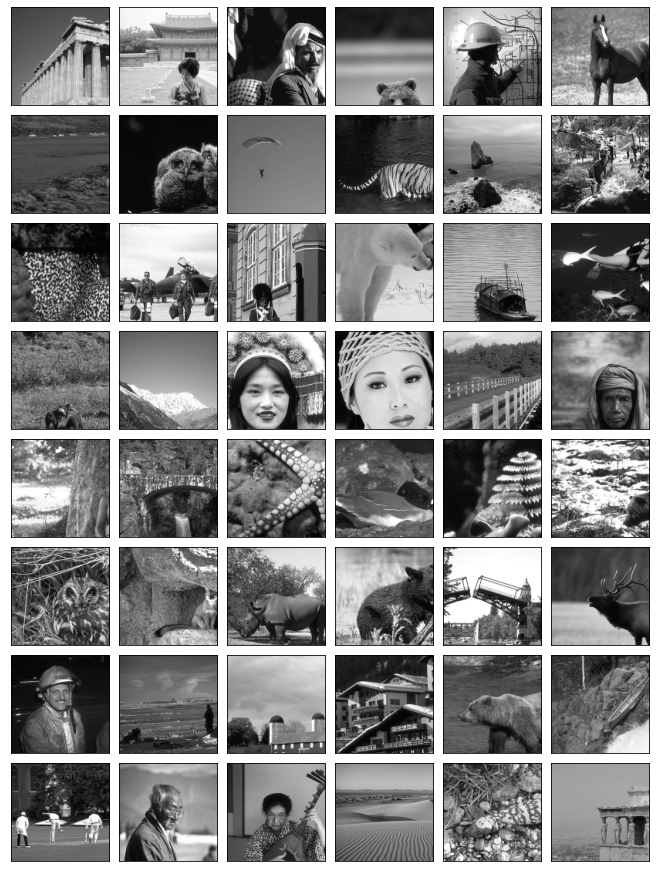


################################################################################
#
# RESULT # 02
#
################################################################################

[plot examples of the training blur images]



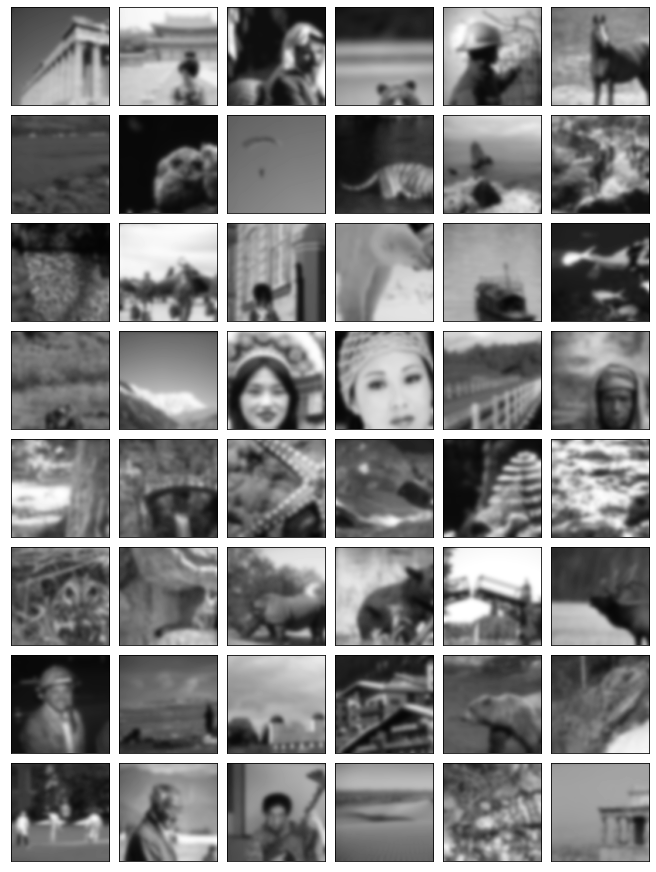


################################################################################
#
# RESULT # 03
#
################################################################################

[plot examples of the training de-blurring results]



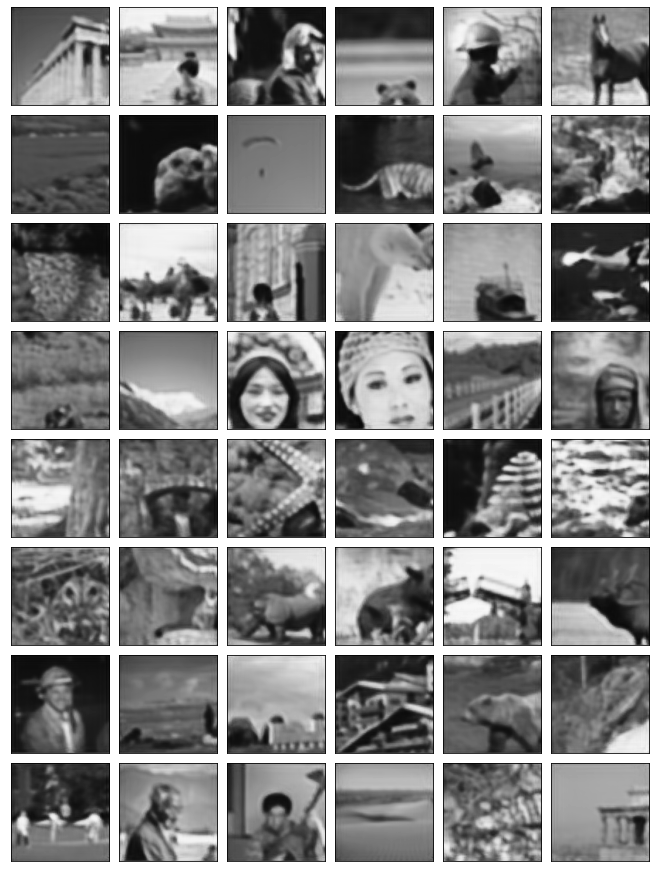


################################################################################
#
# RESULT # 04
#
################################################################################

[plot examples of the testing original images]



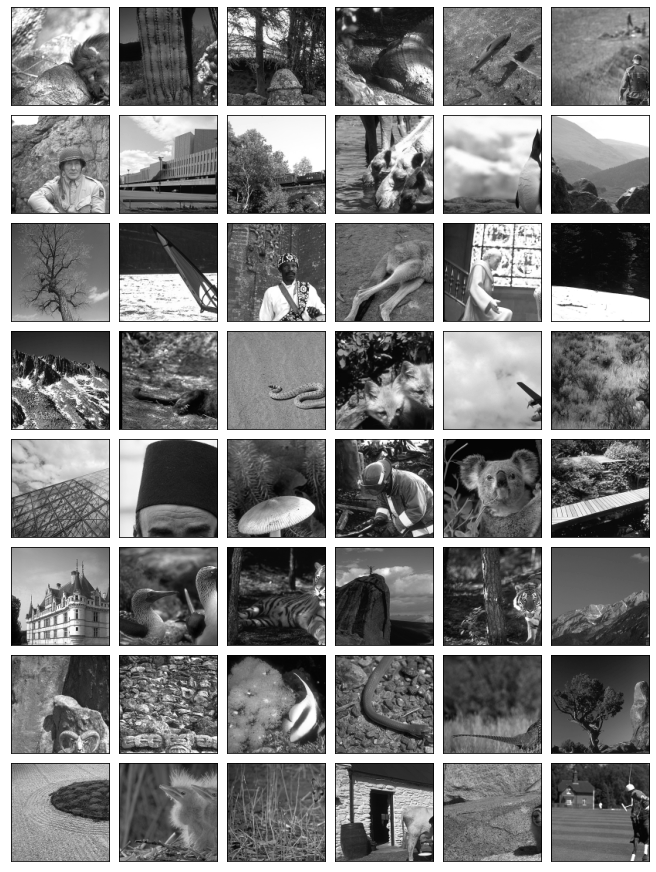


################################################################################
#
# RESULT # 05
#
################################################################################

[plot examples of the testing blur images]



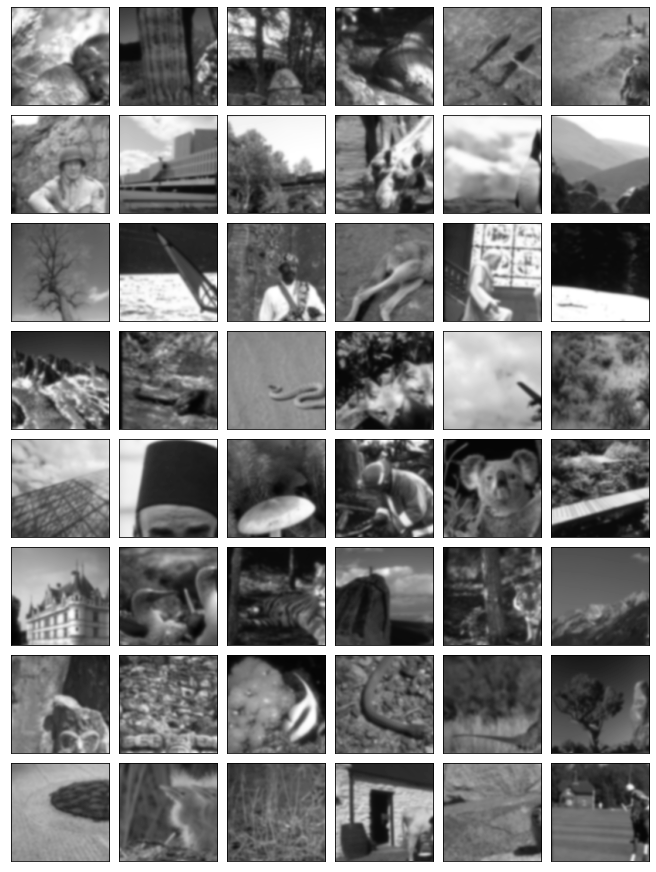


################################################################################
#
# RESULT # 06
#
################################################################################

[plot examples of the testing de-blurring results]



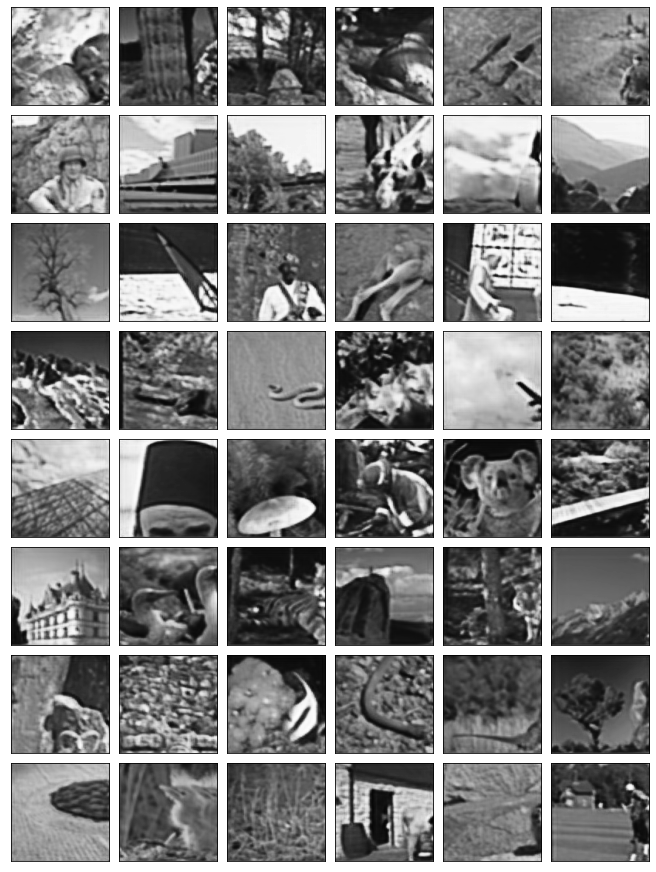


################################################################################
#
# RESULT # 07
#
################################################################################

[plot the training loss]



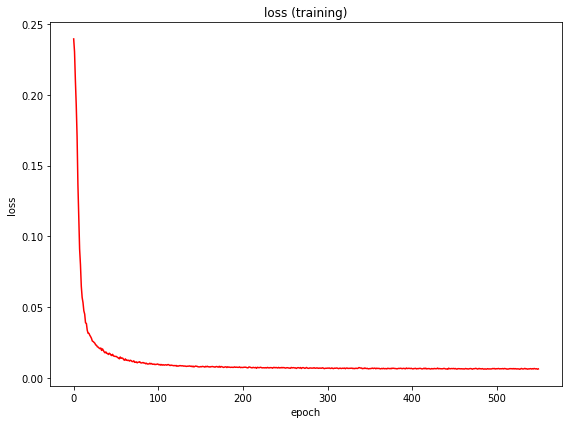


################################################################################
#
# RESULT # 08
#
################################################################################

[plot the training accuracy]



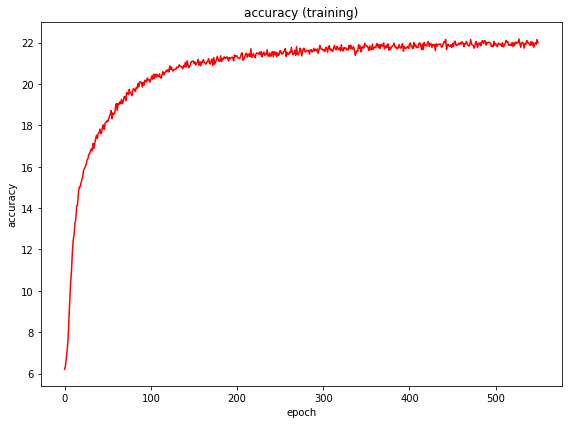


################################################################################
#
# RESULT # 09
#
################################################################################

[plot the testing loss]



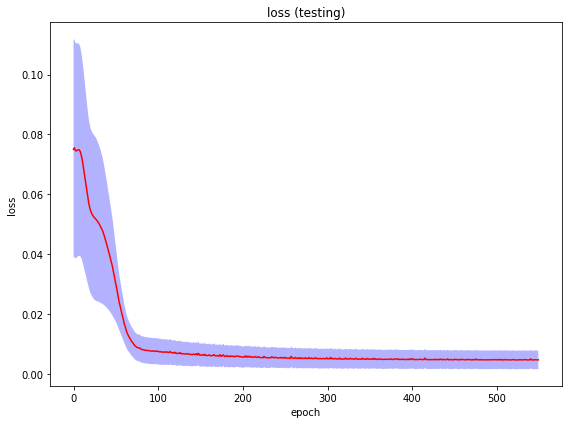


################################################################################
#
# RESULT # 10
#
################################################################################

[plot the testing accuracy]



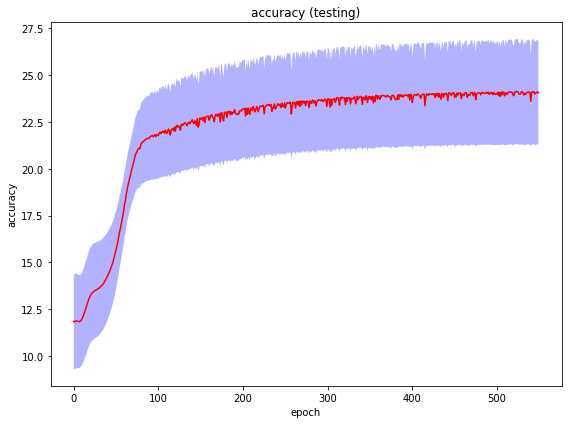


################################################################################
#
# RESULT # 11
#
################################################################################

[print the training loss at the last 10 epochs]

index =  0, value = 0.0065099010
index =  1, value = 0.0062411642
index =  2, value = 0.0064935014
index =  3, value = 0.0062781605
index =  4, value = 0.0066375672
index =  5, value = 0.0064261090
index =  6, value = 0.0063233781
index =  7, value = 0.0064324080
index =  8, value = 0.0061039464
index =  9, value = 0.0063247476

################################################################################
#
# RESULT # 12
#
################################################################################

[print the training accuracy at the last 10 epochs]

index =  0, value = 21.8642578125
index =  1, value = 22.0473461151
index =  2, value = 21.8752117157
index =  3, value = 22.0216751099
index =  4, value = 21.7799110413
index =  5, value = 21.9205207825


In [439]:
number_result = 16

for i in range(number_result):

    title           = '# RESULT # {:02d}'.format(i+1) 
    name_function   = 'function_result_{:02d}()'.format(i+1)

    print('') 
    print('################################################################################')
    print('#') 
    print(title)
    print('#') 
    print('################################################################################')
    print('') 

    eval(name_function)